In [1]:
import pandas as pd

# Load dataset
df = pd.read_csv(r"C:\Users\Asus\Desktop\AIDI2ndSemester\AI Project\Final\processed_delay_data.csv")

# Preview data
print(df.head())
print(df.columns)
print(df.info())


       Date  Time     Day                Station   Code  Min Delay  Min Gap  \
0  1/1/2018  0:29  Monday  SHEPPARD WEST STATION  MUATC         10       15   
1  1/1/2018  1:22  Monday         MUSEUM STATION   MUSC          0        0   
2  1/1/2018  1:39  Monday         MUSEUM STATION    MUO          6       11   
3  1/1/2018  2:09  Monday        KIPLING STATION  MUSAN          3        7   
4  1/1/2018  2:42  Monday        COLLEGE STATION   SUDP          7       12   

  Bound Line  Vehicle Delay_Category  Hour Time_Category  Is_Weekend  Month  \
0     N   YU     5986         Medium     0       Morning       False      1   
1     N   YU     5751          Short     1       Morning       False      1   
2     S   YU     5781         Medium     1       Morning       False      1   
3     E   BD     5261          Short     2       Morning       False      1   
4     N   YU     5696         Medium     2       Morning       False      1   

   Is_Peak_Hour  
0             0  
1             

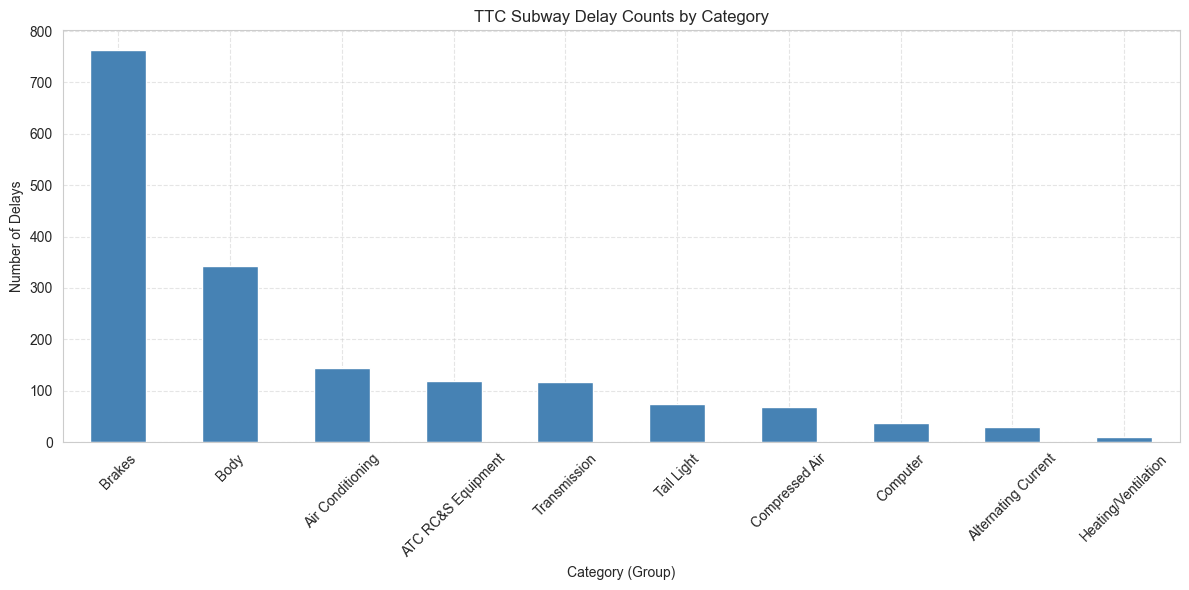

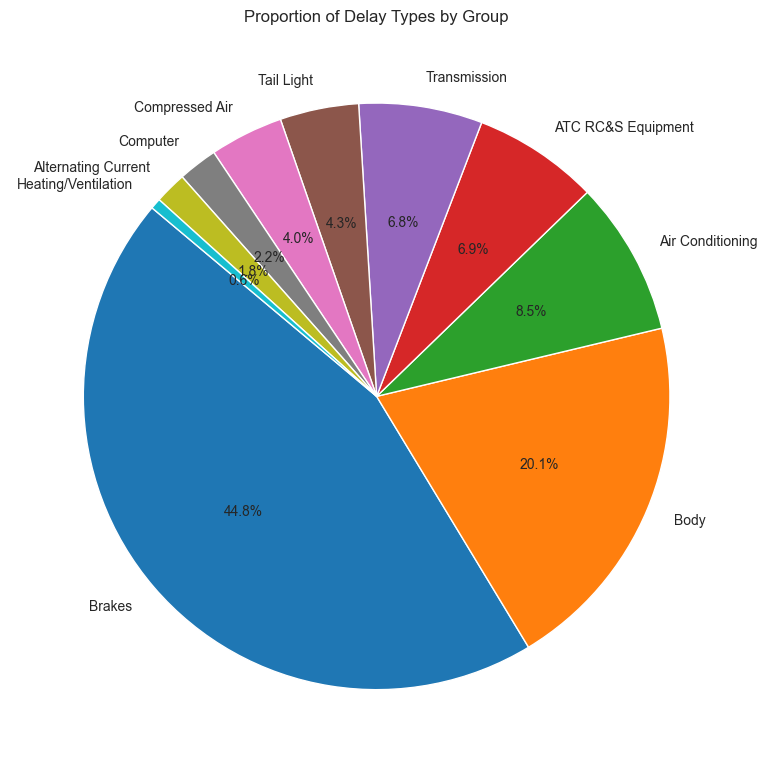

In [17]:
import pandas as pd
import json
import matplotlib.pyplot as plt

# Step 1: Load historical delay dataset
delay_data = pd.read_csv(r"C:\Users\Asus\Desktop\AIDI2ndSemester\AI Project\Final\processed_delay_data.csv")

# Step 2: Load code-group mapping from JSON
with open(r"C:\Users\Asus\DelayPrediction\ttc_code_description.json", "r") as f:
    code_to_group = json.load(f)

# Step 3: Map delay codes to group/category
delay_data['Group'] = delay_data['Code'].map(code_to_group)

# Step 4: Count number of delays per group
group_counts = delay_data['Group'].value_counts()

# Step 5: Plot Bar Chart
plt.figure(figsize=(12, 6))
group_counts.plot(kind='bar', color='steelblue')
plt.title("TTC Subway Delay Counts by Category")
plt.xlabel("Category (Group)")
plt.ylabel("Number of Delays")
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

# Step 6: Pie Chart (Optional)
plt.figure(figsize=(8, 8))
group_counts.plot(kind='pie', autopct='%1.1f%%', startangle=140)
plt.title("Proportion of Delay Types by Group")
plt.ylabel("")
plt.tight_layout()
plt.show()


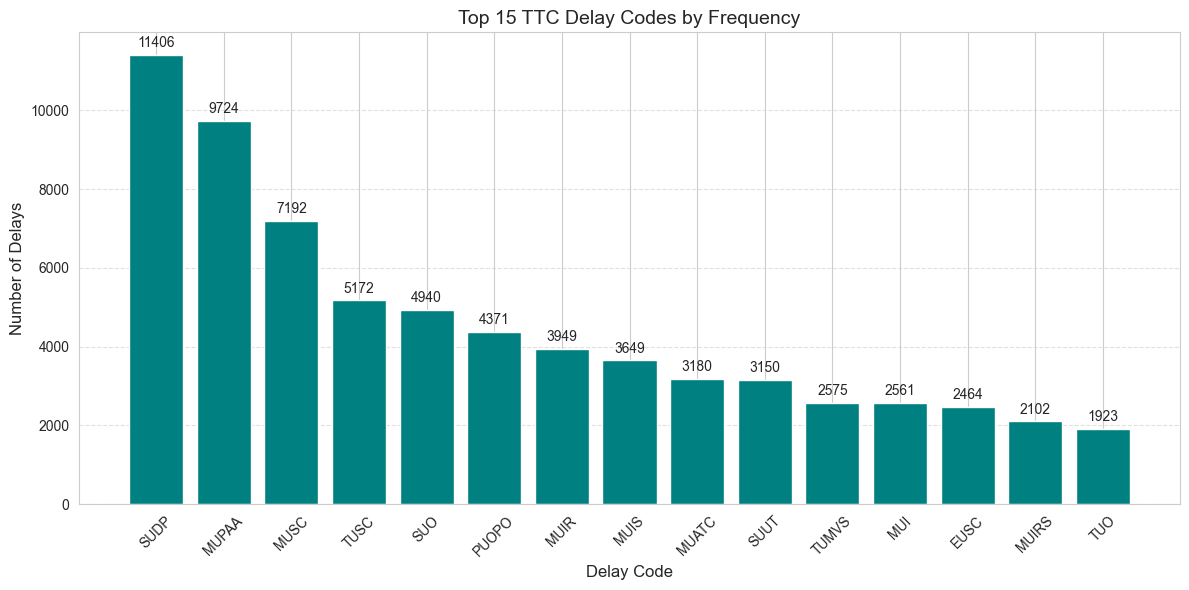

In [19]:
import pandas as pd
import matplotlib.pyplot as plt

# Load your processed dataset
df = pd.read_csv(r"C:\Users\Asus\Desktop\AIDI2ndSemester\AI Project\Final\processed_delay_data.csv")

# Count frequency of each delay code
code_counts = df['Code'].value_counts()

# Select top 15 codes with most delays
top_codes = code_counts.head(15)

# Plotting
plt.figure(figsize=(12, 6))
bars = plt.bar(top_codes.index, top_codes.values, color='teal')
plt.title('Top 15 TTC Delay Codes by Frequency', fontsize=14)
plt.xlabel('Delay Code', fontsize=12)
plt.ylabel('Number of Delays', fontsize=12)
plt.xticks(rotation=45)

# Add value labels on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 200, '%d' % int(height), ha='center', fontsize=10)

plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()


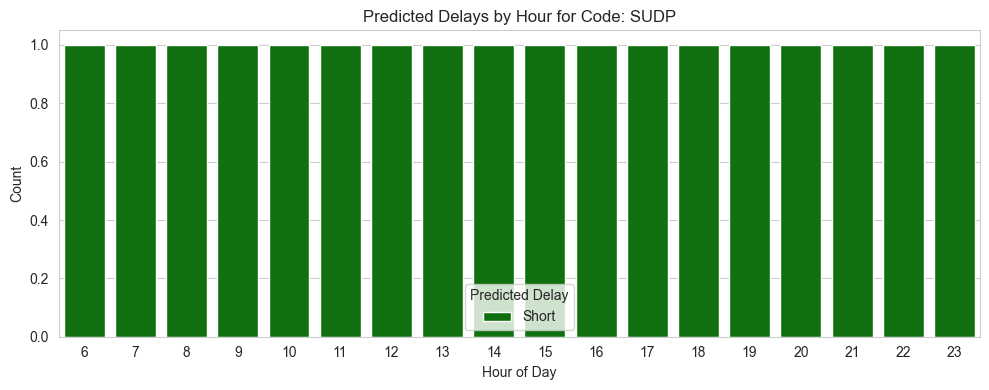

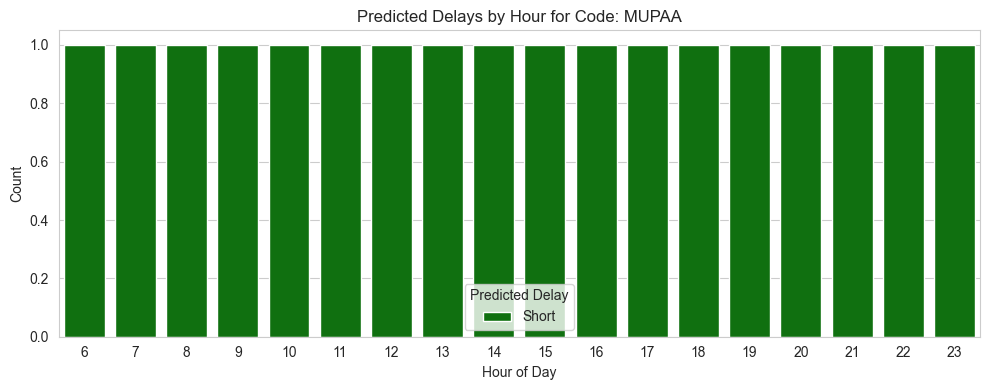

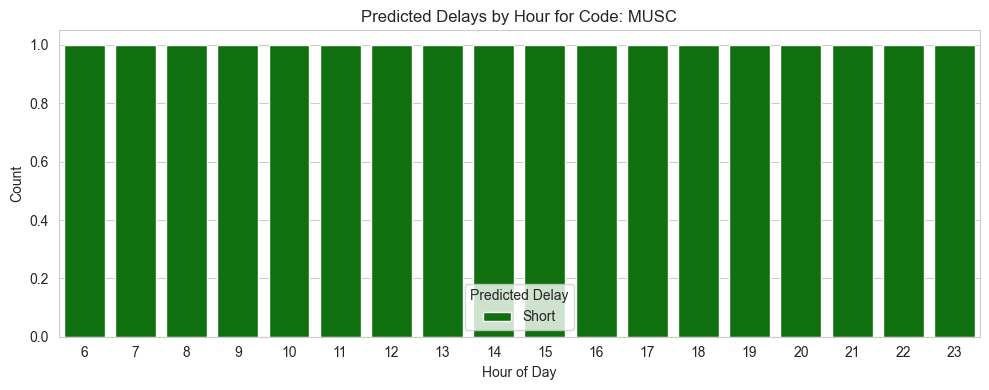

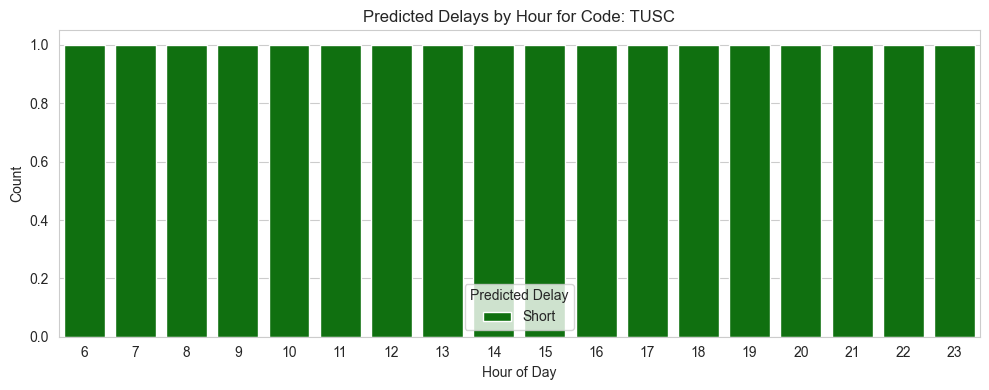

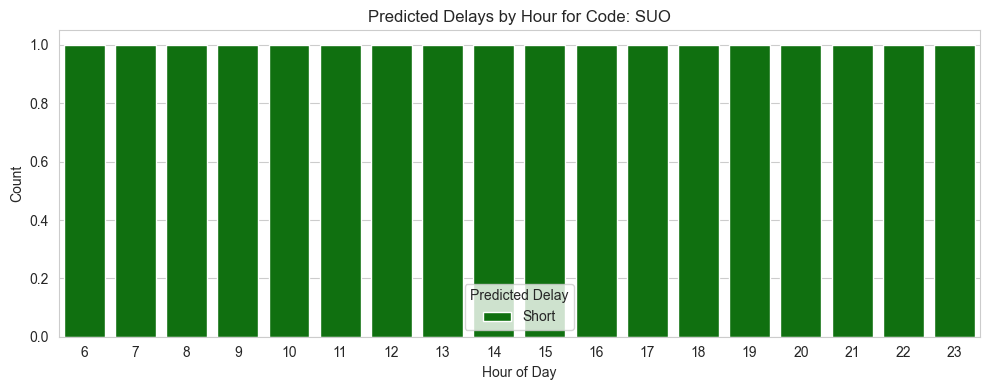

In [20]:
import pandas as pd
import numpy as np
import pickle
from datetime import datetime
import matplotlib.pyplot as plt

# --- Load model and encoders ---
with open("model/delay_model.pkl", "rb") as f:
    model = pickle.load(f)

with open("model/target_encoder.pkl", "rb") as f:
    target_encoder = pickle.load(f)

with open("model/label_encoders.pkl", "rb") as f:
    label_encoders = pickle.load(f)

# Top delay codes to simulate
top_delay_codes = ['SUDP', 'MUPAA', 'MUSC', 'TUSC', 'SUO']

# Simulate predictions for each code across hours
results = []

for code in top_delay_codes:
    for hour in range(6, 24):  # 6 AM to 11 PM
        row = {
            "Date": "2025-08-06",
            "Hour": hour,
            "Station": "St George",  # a common station
            "Day": "Wednesday",
            "Month": 8,
            "Is_Weekend": False,
            "Is_Peak_Hour": int(hour in list(range(7, 10)) + list(range(16, 19))),
            "Time_Category": (
                "Morning" if hour < 12 else
                "Afternoon" if hour < 17 else
                "Evening"
            ),
            "Code": code,
            "Bound": "N",
            "Line": "YU",
            "Vehicle": 0,
            "Min Gap": 0,
        }

        df = pd.DataFrame([row])

        # Encode using label encoders
        for col in ['Day', 'Station', 'Code', 'Bound', 'Line', 'Time_Category']:
            le = label_encoders[col]
            df[col] = df[col].apply(lambda x: x if x in le.classes_ else le.classes_[0])
            df[col] = le.transform(df[col])

        # Keep only model features
        feature_cols = ['Day', 'Station', 'Code', 'Min Gap', 'Bound', 'Line', 'Vehicle',
                        'Hour', 'Time_Category', 'Is_Weekend', 'Month', 'Is_Peak_Hour']
        features = df[feature_cols]

        # Predict
        prediction = model.predict(features)
        delay_label = target_encoder.inverse_transform(prediction)[0]

        results.append({
            "Code": code,
            "Hour": hour,
            "Delay": delay_label
        })

# Convert to DataFrame
df_result = pd.DataFrame(results)

# Pivot table: Delay count per category per code
pivot = pd.crosstab(index=[df_result['Code'], df_result['Hour']], columns=df_result['Delay'])

# --- Visualization ---
import seaborn as sns

for code in top_delay_codes:
    plt.figure(figsize=(10, 4))
    subset = df_result[df_result["Code"] == code]
    sns.countplot(data=subset, x="Hour", hue="Delay", palette={"Short": "green", "Medium": "orange", "Long": "red"})
    plt.title(f"Predicted Delays by Hour for Code: {code}")
    plt.xlabel("Hour of Day")
    plt.ylabel("Count")
    plt.legend(title="Predicted Delay")
    plt.tight_layout()
    plt.show()


C:\Users\Asus\AppData\Local\Temp\ipykernel_23876\309180465.py:91: UserWarning: Glyph 128205 (\N{ROUND PUSHPIN}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\Asus\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128205 (\N{ROUND PUSHPIN}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


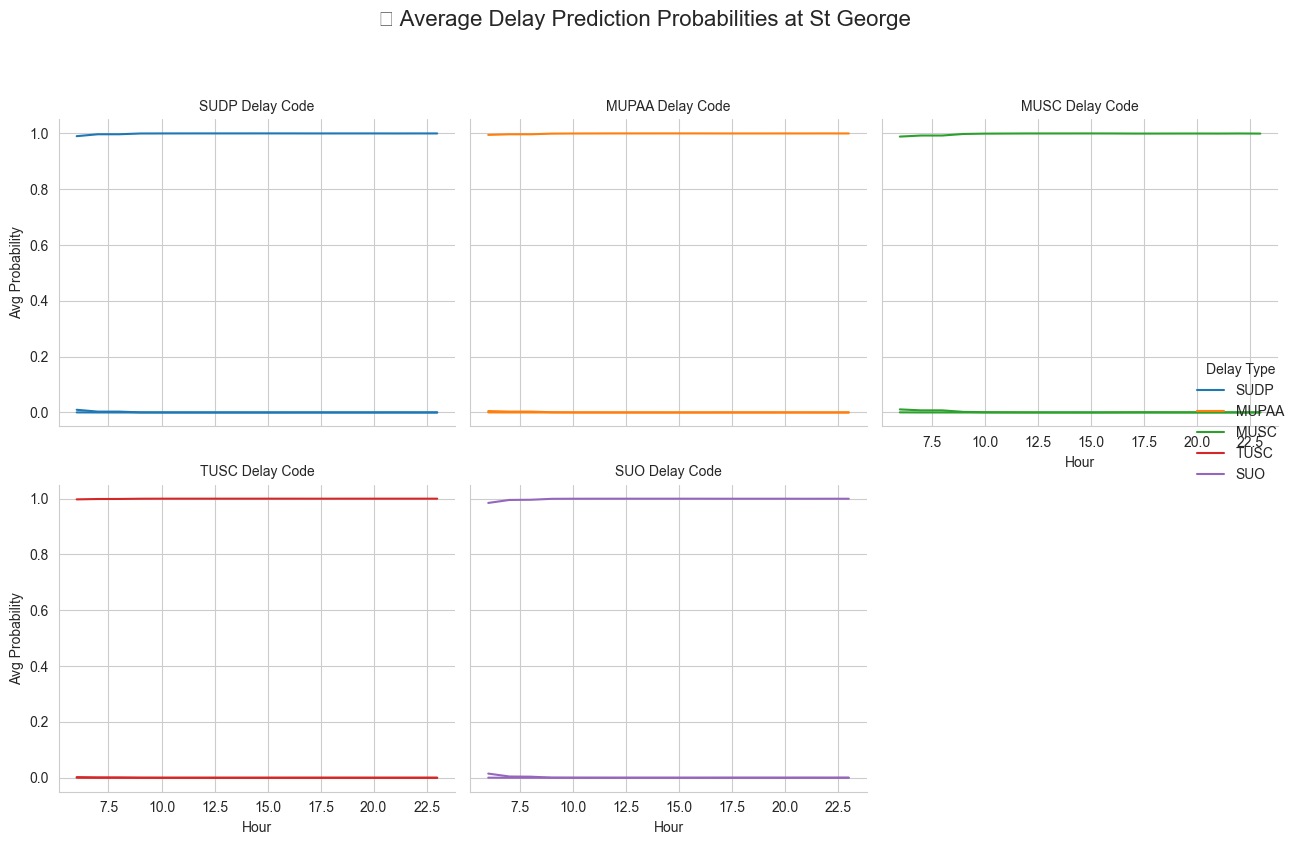

C:\Users\Asus\AppData\Local\Temp\ipykernel_23876\309180465.py:91: UserWarning: Glyph 128205 (\N{ROUND PUSHPIN}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\Asus\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128205 (\N{ROUND PUSHPIN}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


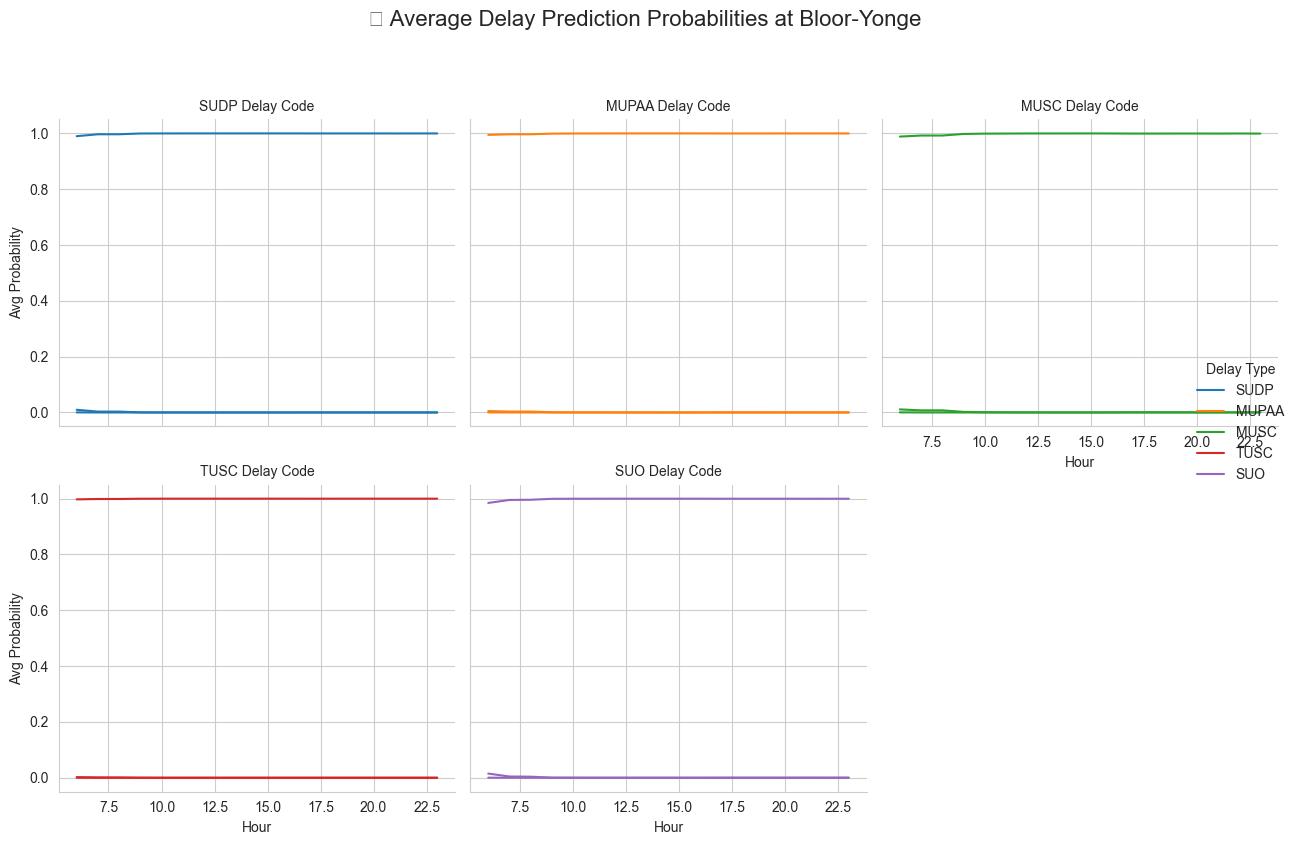

C:\Users\Asus\AppData\Local\Temp\ipykernel_23876\309180465.py:91: UserWarning: Glyph 128205 (\N{ROUND PUSHPIN}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\Asus\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128205 (\N{ROUND PUSHPIN}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


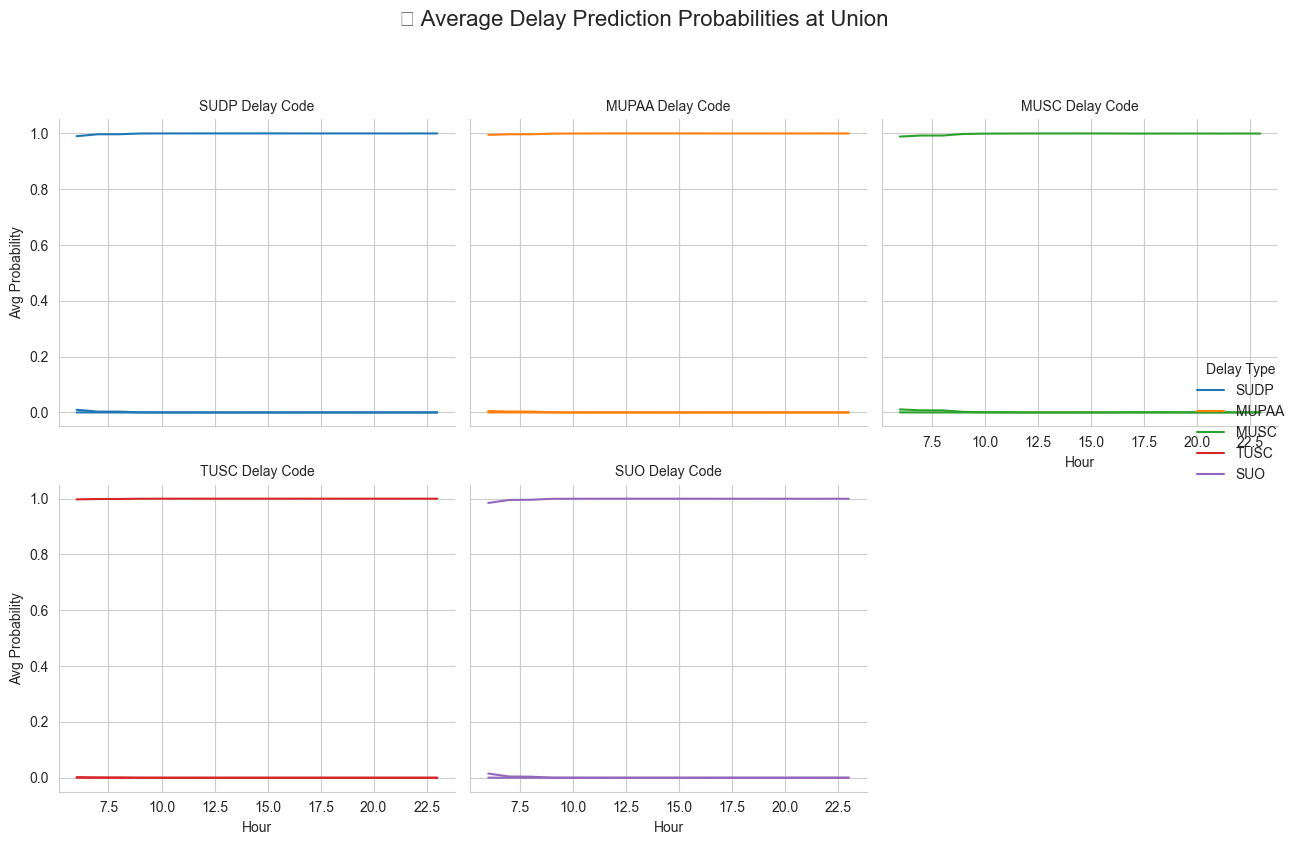

C:\Users\Asus\AppData\Local\Temp\ipykernel_23876\309180465.py:91: UserWarning: Glyph 128205 (\N{ROUND PUSHPIN}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\Asus\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128205 (\N{ROUND PUSHPIN}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


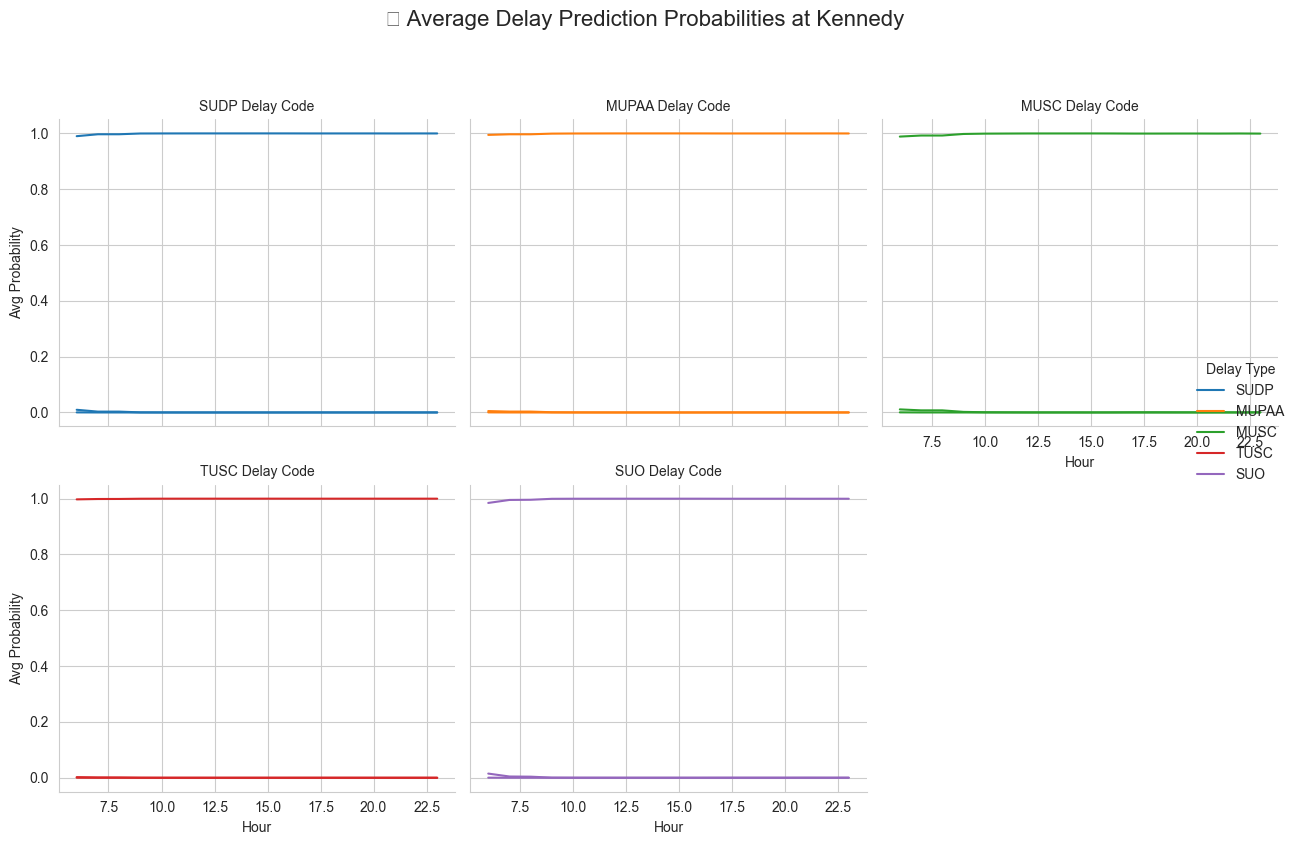

C:\Users\Asus\AppData\Local\Temp\ipykernel_23876\309180465.py:91: UserWarning: Glyph 128205 (\N{ROUND PUSHPIN}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\Asus\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128205 (\N{ROUND PUSHPIN}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


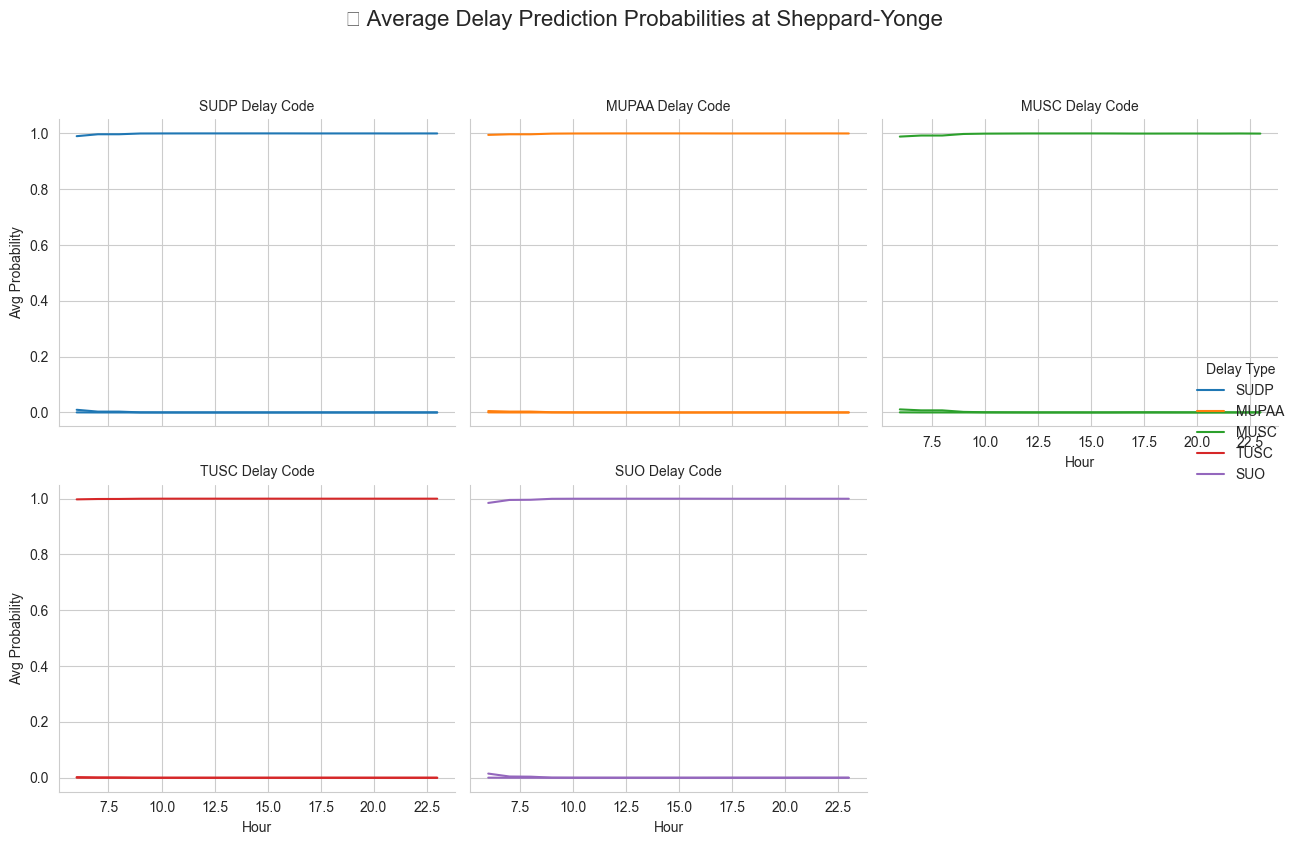

In [22]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Load model and encoders
with open("model/delay_model.pkl", "rb") as f:
    model = pickle.load(f)

with open("model/target_encoder.pkl", "rb") as f:
    target_encoder = pickle.load(f)

with open("model/label_encoders.pkl", "rb") as f:
    label_encoders = pickle.load(f)

# Define top delay codes
top_codes = ['SUDP', 'MUPAA', 'MUSC', 'TUSC', 'SUO']

# Define stations of interest
stations = ["St George", "Bloor-Yonge", "Union", "Kennedy", "Sheppard-Yonge"]

# Target classes in correct order
delay_categories = list(target_encoder.classes_)

# Collect results
records = []

for station in stations:
    for code in top_codes:
        for hour in range(6, 24):  # 6 AM to 11 PM
            # Build the input row
            row = {
                "Date": "2025-08-06",
                "Hour": hour,
                "Station": station,
                "Day": "Wednesday",
                "Month": 8,
                "Is_Weekend": False,
                "Is_Peak_Hour": int(hour in list(range(7, 10)) + list(range(16, 19))),
                "Time_Category": (
                    "Morning" if hour < 12 else
                    "Afternoon" if hour < 17 else
                    "Evening"
                ),
                "Code": code,
                "Bound": "N",
                "Line": "YU",
                "Vehicle": 0,
                "Min Gap": 0,
            }

            df = pd.DataFrame([row])

            # Label encode necessary columns
            for col in ['Day', 'Station', 'Code', 'Bound', 'Line', 'Time_Category']:
                le = label_encoders[col]
                df[col] = df[col].apply(lambda x: x if x in le.classes_ else le.classes_[0])
                df[col] = le.transform(df[col])

            # Predict probabilities
            X = df[['Day', 'Station', 'Code', 'Min Gap', 'Bound', 'Line', 'Vehicle',
                    'Hour', 'Time_Category', 'Is_Weekend', 'Month', 'Is_Peak_Hour']]
            proba = model.predict_proba(X)[0]
            decoded_proba = dict(zip(target_encoder.inverse_transform(np.arange(len(proba))), proba))

            # Store with station and code
            records.append({
                "Station": station,
                "Code": code,
                "Hour": hour,
                **decoded_proba
            })

# Convert to DataFrame
df_result = pd.DataFrame(records)

# --- Plotting Station-wise Breakdown ---
for station in stations:
    df_station = df_result[df_result["Station"] == station]
    g = sns.FacetGrid(df_station, col="Code", hue="Code", height=4, col_wrap=3)

    for delay_type in delay_categories:
        g.map_dataframe(sns.lineplot, x="Hour", y=delay_type, label=delay_type)

    g.set_titles(col_template="{col_name} Delay Code")
    g.set_axis_labels("Hour", "Avg Probability")
    g.add_legend(title="Delay Type")
    g.fig.suptitle(f"📍 Average Delay Prediction Probabilities at {station}", fontsize=16, y=1.05)
    plt.tight_layout()
    plt.show()


In [2]:
from sklearn.preprocessing import LabelEncoder

# List of categorical columns to encode
categorical_cols = ['Day', 'Station', 'Code', 'Bound', 'Line', 'Time_Category']

# Apply label encoding
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le  # Save encoder for later use

# Also encode Delay_Category (our target)
target_encoder = LabelEncoder()
df['Delay_Category'] = target_encoder.fit_transform(df['Delay_Category'])


In [3]:
# Define features and target
X = df.drop(columns=['Min Delay', 'Delay_Category', 'Date', 'Time'])  # drop unneeded columns
y = df['Delay_Category']


In [4]:
from sklearn.model_selection import train_test_split

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [6]:
from sklearn.utils.class_weight import compute_class_weight
from xgboost import XGBClassifier
from sklearn.metrics import classification_report
import numpy as np

# Get class weights for imbalance
class_weights = compute_class_weight(class_weight='balanced',
                                     classes=np.unique(y),
                                     y=y)

# Convert to dictionary {class_index: weight}
weight_dict = {i: weight for i, weight in enumerate(class_weights)}
print("Class Weights:", weight_dict)

# Train XGBoost with class weights
model = XGBClassifier(
    random_state=42,
    use_label_encoder=False,
    eval_metric='mlogloss',
    scale_pos_weight=1  # we won't use this, just custom weights per class
)

# Manually map class weights to sample weights
sample_weights = y_train.map(lambda x: weight_dict[x])

# Train model with weights
model.fit(X_train, y_train, sample_weight=sample_weights)


Class Weights: {0: np.float64(8.468290330359295), 1: np.float64(2.107796650861293), 2: np.float64(0.41537151373216946)}


C:\Users\Asus\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [17:59:21] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "scale_pos_weight", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

              precision    recall  f1-score   support

        Long       0.88      0.93      0.90       830
      Medium       0.77      0.93      0.84      3332
       Short       0.99      0.94      0.97     16909

    accuracy                           0.94     21071
   macro avg       0.88      0.93      0.90     21071
weighted avg       0.95      0.94      0.94     21071



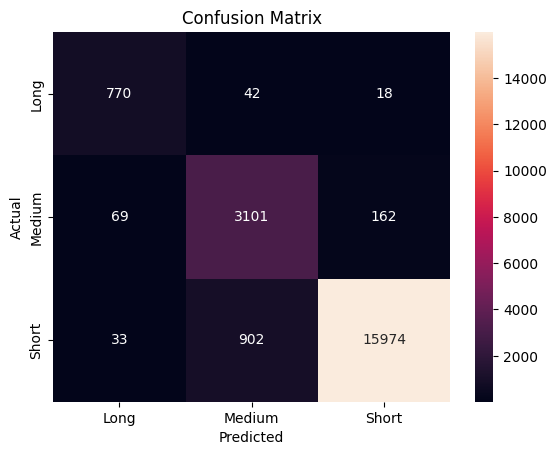

In [7]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Predict and evaluate
y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred, target_names=target_encoder.classes_))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=target_encoder.classes_, yticklabels=target_encoder.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [11]:
import pickle
import os

# Create a folder to store models
os.makedirs("model", exist_ok=True)

# Save model
with open("DelayPrediction/model/delay_model.pkl", "wb") as f:
    pickle.dump(model, f)

# Save target encoder
with open("DelayPrediction/model/target_encoder.pkl", "wb") as f:
    pickle.dump(target_encoder, f)

# Save label encoders
with open("DelayPrediction/model/label_encoders.pkl", "wb") as f:
    pickle.dump(label_encoders, f)

print("✅ Model and encoders saved successfully.")


✅ Model and encoders saved successfully.


In [9]:
!pip install holidays



[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [10]:
import random
import holidays
from datetime import datetime

# Define Canadian holidays
can_holidays = holidays.CA(prov='ON')  # Ontario

def apply_custom_rules(row):
    month = row["Month"]
    hour = row["Hour"]
    is_weekend = row["Is_Weekend"]
    is_peak = row["Is_Peak_Hour"]
    date_obj = datetime.strptime(row["Date"], "%Y-%m-%d")
    
    # Holiday rule
    if date_obj in can_holidays:
        return random.choice(["Short", "Medium", "Long"])
    
    # Winter months rule
    if month in [12, 1, 2]:
        return random.choices(["Medium", "Long"], weights=[0.6, 0.4])[0]
    
    # Weekend rule
    if is_weekend:
        return random.choices(["Short", "Medium"], weights=[0.7, 0.3])[0]

    # Rush hour
    if is_peak == 1:
        return random.choice(["Short", "Medium", "Long"])

    return None  # Let model prediction be used
